# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector

import data_processing as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'data_processing' from '/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/data_processing.py'>

# Configure path to data files

In [2]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "D:/youniverse/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon

# Preprocessing

## Loading the data

In [3]:
# load channel data (no chunks needed, as the file is not very large)
df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") #andreas 
# df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv", compression="infer", sep="\t") # manon 

In [4]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data
df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) #andreas 
# df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", compression="infer", lines=True, nrows=1000000) #manon
# load (first 1000000 rows of) comment data
df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000) #andreas
# df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv", compression="infer", sep="\t", nrows=1000000) #manon

In [5]:
df_channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [6]:
# definition of "readers", i.e., objects that we can iterate through 
# and always get a chunk of the dataframe in each iteration

def videos_in_chunks(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", #andreas
    # return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", #manon
                        compression="infer", lines=True, chunksize=chunksize, )
                        # nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", #andreas
    # return pd.read_csv(dataset_root_path + "youtube_comments.tsv", #manon
                       compression="infer", sep="\t", chunksize=chunksize, )
                    #    nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

# Intro : topics distribution on YouTube
With this analysis we want to show that News&Politics is a popular category of both videos and channels to justify our choice.  

,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22951
4,Film and Animation,6875
5,Gaming,20143
6,Howto & Style,11875
7,Music,24285
8,News & Politics,2263
9,Nonprofits & Activism,969


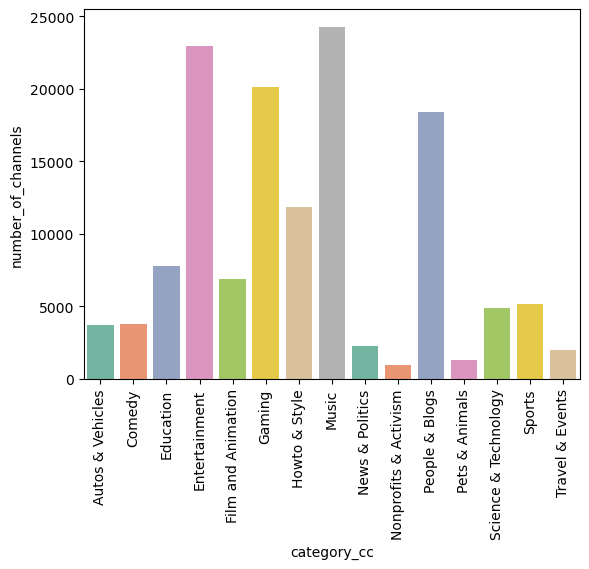

In [172]:
#distribution of categories for the channels 
category_channel= df_channels.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
display(category_channel)
ax = sns.barplot(x="category_cc", y="number_of_channels", data=category_channel,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.show()

#instead of saying it goes in our way we could say , that it is already a small category which can lead to more isolation as people are less interested 
#and there exists less various sources thus clustering can happen more easily 

,categories,number_of_videos
0,,2
1,Autos & Vehicles,738
2,Comedy,4197
3,Education,3326
4,Entertainment,22685
5,Film & Animation,1225
6,Gaming,21057
7,Howto & Style,4857
8,Music,13442
9,News & Politics,7347


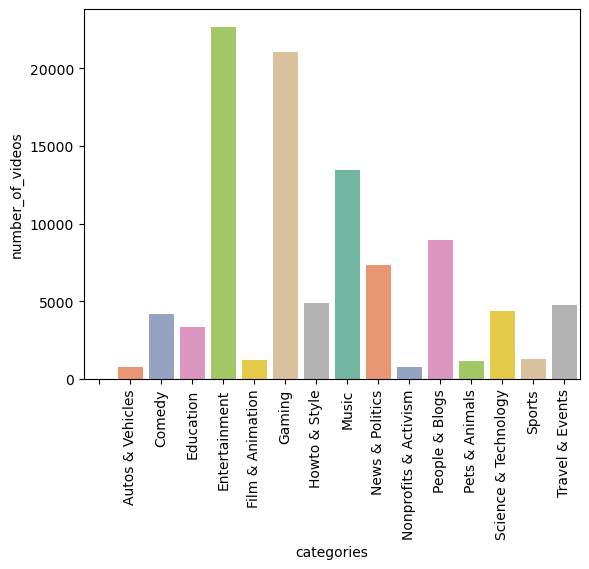

In [173]:
#distribution of categories for the videos for the first 100000 rows 

category_videos= df_videos.groupby('categories').agg(number_of_videos=('categories', 'size')).reset_index()
display(category_videos)
ax = sns.barplot(x="categories", y="number_of_videos", data=category_videos,hue="categories", palette='Set2')
plt.xticks(rotation=90)
plt.show()

#even if it isnt on the whole dataset (only on 1000000 first rows) we see here that the news & politics is a popular category for videos comapred to channels 

# Note:
Some videos don't seem to have a category.

So we should check for this and remove that maybe, or at least mention it in our analysis,

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
3.896 secs per chunk on average. Meaning  47.287 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
3.775 secs per chunk on average. Meaning  45.758 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
3.786 secs per chunk on average. Meaning  45.828 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.753 secs per chunk on average. Meaning  45.361 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.661 secs per chunk on average. Meaning  44.185 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.604 secs per chunk on average. Meaning  43.439 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.611 secs per chunk

,category,number_of_videos
0,,1
1,Autos & Vehicles,1
2,Comedy,1
3,Education,1
4,Entertainment,1
5,Film & Animation,1
6,Gaming,1
7,Howto & Style,1
8,Movies,1
9,Music,1


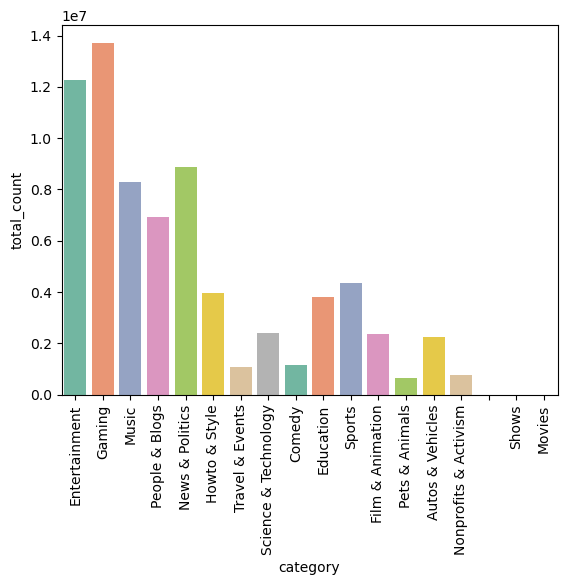

In [174]:
#distribution categories of videos over the whole dataset per chunck

# Define a function that processes a single chunk
def count_videos_by_category(chunk):
    # Count videos in each category within the chunk
    category_counts = chunk['categories'].value_counts().to_frame().T  # Get counts and transpose for one-row DataFrame
    category_counts.columns.name = None  # Remove column name for easy concatenation
    return category_counts

# Apply the function to all chunks and get the results concatenated
category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
    videos_in_chunks(chunksize=100000), 
    count_videos_by_category,
    print_time=(100000, 72924794)
)

# Sum the counts across all chunks to get the total count of videos per category
total_category_counts = category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
total_category_counts.columns = ['category', 'total_count']

total_category_counts.to_csv("../data/video_count_by_category.csv")  # save the created dataframe so we don't have to generate it again

# Display the final distribution
print(total_category_counts)

category_videos_whole_dataset= total_category_counts.groupby('category').agg(number_of_videos=('category', 'size')).reset_index()
display(category_videos_whole_dataset)
ax = sns.barplot(x="category", y="total_count", data=total_category_counts,hue="category", palette='Set2')
plt.xticks(rotation=90)
plt.show()

In [7]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


## Filtering for NaNs and ' ' (here in youtube_comments.tsv.gz)

Pending questions to TA (good practices): 
- is the analysis of useless data (NaN and '' rows) required for justification of their removal, or can we just go with the filtering only ?
- are we allowed to filter once the dataset is already reduced to e.g one channel, or do we have to filter in the very beginning (painful) ?

# Note
This will likely not work on the whole dataframe, because it's going to be (almost) as large as the initial comments dataset, and hence to large too large to handle. Therefore, it is in particular also too large to generate like this.

In [176]:
# #replace empty character '' with NaN and remove rows containing NaN

# filtered_df = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                         lambda x: x.replace('', np.nan).dropna(),
#                                         print_time=(1000000, 8600000000))

In [177]:
#filtered df
# display(filtered_df)

If we have to analyze NaN rows before filtering, then use this code:

In [178]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# # get the entries of the comment dataframe which have a na value in any column
# nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                         lambda x: dp.get_na_entries(x, "any", reverse=False),
#                                         print_time=(1000000, 8600000000))

# nans.to_csv("../data/nan_rows_in_comment_dataset.csv")

In [179]:
# display(nans)

In [180]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


In [181]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# # count the entries of the comment dataframe which have a na value in any column

# counted_nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                                 lambda x: dp.count_na_entries(x, "any", reverse=False),
#                                                 print_time=(1000000, 8600000000)).sum(axis=0)

# counted_nans.to_csv("../data/counted_nans_in_comment_data.csv")

In [182]:
# display(counted_nans)

In [8]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


## Filtering the datasets to our needs

### Filtering **videos** by category 'News & Politics'

In [9]:
# filter the video dataframe to only include videos from n&p category

df_videos_news_pol = dp.run_simple_function_on_chunks_concat(videos_in_chunks(chunksize=100000),
                                                             lambda x: x[x.categories == "News & Politics"], 
                                                             print_time=(100000, 72924794),
                                                             save=dataset_root_path + "/../generated_data/videos_in_news_pol",
                                                             save_every=300,
                                                             compress=".gz")

# df_videos_news_pol.to_csv("../data/videos_in_news_pol.csv")

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
3.971 secs per chunk on average. Meaning  48.203 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.050 secs per chunk on average. Meaning  49.091 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
4.080 secs per chunk on average. Meaning  49.390 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.967 secs per chunk on average. Meaning  47.956 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.805 secs per chunk on average. Meaning  45.925 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.696 secs per chunk on average. Meaning  44.555 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.690 secs per chunk

In [10]:
display(df_videos_news_pol)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
60001328,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:29.025236,If you're joining American Towman for the annu...,0.0,QThfRHnKbCw,274,0.0,"12,08,02,ATTV,Show,Saturday,720p","San Antonio ""Tow Expo International"" -- Day 2:...",2012-08-02 00:00:00,163.0
60001333,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:32.818688,There are several ways some companies steal or...,6.0,4MI_MPfl5bI,251,52.0,"poaching,youtube",The Dirty Business of Poaching Tow Calls,2012-07-03 00:00:00,13910.0
60001334,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:36.714021,A woman's story of being set on fire strikes a...,1.0,JGAkibyb8qs,192,2.0,youyube,Tow Boss Assists Woman Set on Fire in Florida,2012-06-28 00:00:00,759.0
60001335,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:40.318780,The rainy summer season in Florida can cause u...,1.0,ZjqHusNm2oA,128,4.0,"Florida,Flooding,youtube",Towman Helps Teens Stuck in Florida Flooding,2012-06-27 00:00:00,463.0
60001343,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:47.870235,Buffalo city officials are changing key towing...,0.0,6lCUY_N-PTY,140,1.0,"buffalo,youtube","Towing Policies Changed in Buffalo, NY in Resp...",2012-05-30 00:00:00,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72924789,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:02.294620,Shri Manoj Kumar Tiwari's speech during Motion...,3.0,YQLoxwLpjSU,270,67.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Manoj Kumar Tiwari's speech during Motion...,2017-02-06 00:00:00,4409.0
72924790,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:06.401481,Shri La Ganesan's speech during Motion of Than...,0.0,mINQHg1QBcg,878,21.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri La Ganesan's speech during Motion of Than...,2017-02-06 00:00:00,1172.0
72924791,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:09.530822,Shri Mukhtar Abbas Naqvi's speech during Motio...,2.0,x20aNOWh1yI,1003,35.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Mukhtar Abbas Naqvi's speech during Motio...,2017-02-06 00:00:00,1898.0
72924792,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:00.080054,BJP submitted complaint to EC against Chief Se...,0.0,-Nn6FL2gqEw,755,27.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",BJP submitted complaint to EC against Chief Se...,2017-02-06 00:00:00,726.0


In [11]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


### Filtering **channels** by category News & Politics

In [12]:
#filter channels dataset to only include n&p
df_channels_news_pol = df_channels[df_channels.category_cc == "News & Politics"]

df_channels_news_pol.to_csv("../data/channels_in_news_pol.csv")

In [13]:
display(df_channels_news_pol)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
129,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.0870
133,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.0870
212,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.0870
268,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.0870
337,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.0870
...,...,...,...,...,...,...,...,...
135820,News & Politics,2010-08-07,UC5rxiCGcNunIi5zI1hMYLMg,Salman Akhtar,10400,40,962468.0,53.1435
135825,News & Politics,2013-02-01,UCLSEJQ8TWtlEkaytaa4Y7lw,WingsOfChrist,10420,61,962547.0,53.1435
135901,News & Politics,2012-10-19,UCnkG_c5cyemVVsgCDoHiXew,The American Mirror,10500,329,963417.0,53.1435
136231,News & Politics,2017-11-25,UC69lWS7UMbBQc-9yqp4nGjA,Patriotism Show,10320,46,975448.0,53.1435


In [14]:
# check if all videos we found in news&pol are also pulished by a channel in category n&p

df_videos_news_pol[np.logical_not(df_videos_news_pol.channel_id.isin(df_channels_news_pol.channel))]



,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
60001328,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:29.025236,If you're joining American Towman for the annu...,0.0,QThfRHnKbCw,274,0.0,"12,08,02,ATTV,Show,Saturday,720p","San Antonio ""Tow Expo International"" -- Day 2:...",2012-08-02 00:00:00,163.0
60001333,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:32.818688,There are several ways some companies steal or...,6.0,4MI_MPfl5bI,251,52.0,"poaching,youtube",The Dirty Business of Poaching Tow Calls,2012-07-03 00:00:00,13910.0
60001334,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:36.714021,A woman's story of being set on fire strikes a...,1.0,JGAkibyb8qs,192,2.0,youyube,Tow Boss Assists Woman Set on Fire in Florida,2012-06-28 00:00:00,759.0
60001335,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:40.318780,The rainy summer season in Florida can cause u...,1.0,ZjqHusNm2oA,128,4.0,"Florida,Flooding,youtube",Towman Helps Teens Stuck in Florida Flooding,2012-06-27 00:00:00,463.0
60001343,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:47.870235,Buffalo city officials are changing key towing...,0.0,6lCUY_N-PTY,140,1.0,"buffalo,youtube","Towing Policies Changed in Buffalo, NY in Resp...",2012-05-30 00:00:00,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72907313,News & Politics,UCrwHteI3lioIHbZF5iDRdBw,2019-10-30 23:46:03.911918,Atlanta Fine Homes 2013 Spring Real Estate Mar...,0.0,SB2XC_yH7WA,264,1.0,"Virtual Studio Innovations,The VSI Group,AFH,A...",Atlanta Fine Homes 2013 Spring Real Estate Mar...,2013-03-07 00:00:00,385.0
72907373,News & Politics,UCrwHteI3lioIHbZF5iDRdBw,2019-10-30 23:46:38.996884,765 East Northway Lane\n\nVirtual Studio Innov...,0.0,2seTjusi7KU,133,8.0,"Heery Brothers,George Heery,Neal Heery,765 Eas...",Atlanta Real Estate Market - 765 East Northway...,2012-07-11 00:00:00,582.0
72907492,News & Politics,UCrwHLlgnIciUKVLGOO_LANg,2019-11-07 01:48:08.384683,#VINAYCONNECTS\nReversed water purifier.\nColo...,0.0,1eTyzeYc8Bg,132,11.0,"Reversed video,coloured water into drinking wa...",Satisfying reverse video,2018-07-25 00:00:00,190.0
72907791,News & Politics,UCrwGDSxsQPqyoy_gZs9ydrw,2019-11-13 02:28:45.404263,TWITTER:@SincerelyOghosa\nINSTAGRAM:@Sincerely...,17.0,VoCUD2DpD_U,184,117.0,"Review,Hair,RPGshow,kim kardashian lace wig,dy...",RPG SHOW LACE WIG REVIEW,2013-08-01 00:00:00,9276.0


**We see that indeed, not all videos in the news and politics category belong to a channel in this category!**
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channe, but not all.

In the paper about the dataset, the authors say that the channel category is actually the "most frequent category", so I guess the video categories are the most relevant, as they are the true categories.

We could try to verify this, if we want to.

In [22]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

31


In [21]:
del df_videos_news_pol

### Filtering the N&P videos by a list of channels

In [16]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, Fox News, BBC News and MSNBC)

df_videos_news_pol_manually_selected = df_videos_news_pol[df_videos_news_pol.channel_id.isin(["UCupvZG-5ko_eiXAupbDfxWw",  # CNN
                                                                                              "UCXIJgqnII2ZOINSWNOGFThA",  # Fox News
                                                                                              "UC16niRr50-MSBwiO3YDb3RA",  # BBC News
                                                                                              "UCaXkIU1QidjPwiAYu6GcHjg",  # MSNBC
                                                                                            ])]

df_videos_news_pol_manually_selected.to_csv("../data/videos_from_news_pol_from_selected_channels.csv")

In [17]:
df_videos_news_pol_manually_selected

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
68255083,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:10:03.077150,Eshan Hilal is one of India's few male belly d...,65.0,RFY4vrpFY9Y,76,213.0,"belly dance,belly dancing,belly dancer,belly d...",The man who fought to be a belly dancer - BBC...,2017-07-08 00:00:00,23938.0
68255084,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:10:06.428106,Amy Seton is called 'the whisky woman' by peop...,18.0,Y54OZswsAl4,80,4.0,"Birmingham,whisky woman,whisky,bbc,bbc news,bb...",Birmingham's whisky woman on creating her own ...,2017-07-08 00:00:00,1379.0
68255085,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:10:08.609607,US President Donald Trump has said he expects ...,90.0,vXvpSWluCc8,56,313.0,"Donald Trump,Theresa May,G20 SUMMIT,bbc,bbc ne...",G20 SUMMIT: Donald Trump meets Theresa May - B...,2017-07-08 00:00:00,55444.0
68255086,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:10:15.919753,It's the G20 this weekend so we've looked into...,157.0,0GNTuz2DuGU,68,458.0,"world leaders,bbc,bbc news,bbc live coverage,b...",How much do world leaders earn? - BBC News,2017-07-08 00:00:00,54772.0
68255087,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:10:06.916852,Who had the dominant handshake and who couldn'...,2971.0,P_znacxuhyU,136,1269.0,"Putin Body Language,Body Language,Donald Trump...",G20 SUMMIT: Donald Trump - Vladimir Putin Body...,2017-07-07 00:00:00,370395.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68265504,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:14:19.613488,Subscribe to BBC News www.youtube.com/bbcnews\...,33.0,OLwYm-BoQ4k,88,99.0,"mexico cartel,Mexico (Country),mexico drugs,me...",#BBCTrending: Mexico's 'Cartel Princess' - BBC...,2014-02-03 00:00:00,48393.0
68265505,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:14:23.749718,Subscribe to BBC News www.youtube.com/bbcnews\...,208.0,Ua1i6Csx1KE,265,207.0,"Abhisit Vejjajiva (Politician),vejjajiva inter...",Abhisit Vejjajiva - Thailand 'government has n...,2014-02-03 00:00:00,71281.0
68265506,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:14:26.109955,Subscribe to BBC News www.youtube.com/bbcnews\...,6.0,zhNxHXxp0oA,187,58.0,"Super Bowl,Denver,Seattle,New York City (City/...",SUPER BOWL SEX TRAFFIC CRACKDOWN - BBC NEWS,2014-02-02 00:00:00,15707.0
68265507,News & Politics,UC16niRr50-MSBwiO3YDb3RA,2019-11-01 16:14:30.579508,Subscribe to BBC News www.youtube.com/bbcnews\...,2.0,8Ly_z2hmJGk,136,9.0,"BBC News (TV Program),Afghanistan (Country),af...",How do Afghans feel about their prospects in 2...,2014-02-02 00:00:00,1181.0


### Doing our own ranking of N&P channels (not necessary)

In [ ]:
# sort the previously filtered n&p channels by subscriber count according to channel crawler
#df_channels_news_pol_sort_subscribers = df_channels_news_pol.sort_values(by="subscribers_cc", ascending=False)

In [ ]:
#display(df_channels_news_pol_sort_subscribers)

### Filtering **videos** in a specific channel
Note: This function doesn't have to be done on the whole video dataset, as it is done here, since we have previously filtered N&P videos of specific channels.
Therefore, we would also not need chunks here.

Todo: simplify the function like this:

df_videos_news_pol_manually_selected.loc[df_videos_news_pol_manually_selected.channel_id == <channel id of the desired channel>]


In [23]:
# filter the video dataset to get only videos from a specific channel (here: random channel)

videos_from_channel_test = dp.run_simple_function_on_chunks_concat(
    videos_in_chunks(chunksize=100000),
    lambda x: x.loc[x.channel_id == "UCzWrhkg9eK5I8Bm3HfV-unA"],
    print_time=(100000, 72924794))

videos_from_channel_test.to_csv("../data/videos_from_channel_UCzWrhkg9eK5I8Bm3HfV-unA_test.csv")

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
4.044 secs per chunk on average. Meaning  49.086 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
3.865 secs per chunk on average. Meaning  46.844 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
3.976 secs per chunk on average. Meaning  48.124 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.921 secs per chunk on average. Meaning  47.398 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.811 secs per chunk on average. Meaning  46.005 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.694 secs per chunk on average. Meaning  44.527 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.687 secs per chunk

### Filtering **comments** in a specific channel

This second function probably needs to look like this, as we haven't preprocessed the comment data yet, so it is still too big to be considered all at once, so we need the chunks.

In [ ]:
# get comments on videos from a specific channel using the ids from filtered video dataset

comments_from_channel_test = dp.run_simple_function_on_chunks_concat(
    comments_in_chunks(chunksize=1000000), 
    lambda df: df[df.video_id.isin(videos_from_channel_test.display_id)],
    print_time=(1000000, 8600000000))

comments_from_channel_test.to_csv("../data/comments_from_channel_UCzWrhkg9eK5I8Bm3HfV-unA_test.csv")

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
1.307 secs per chunk on average. Meaning  187.343 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.332 secs per chunk on average. Meaning  190.866 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.380 secs per chunk on average. Meaning  197.719 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.355 secs per chunk on average. Meaning  194.056 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.363 secs per chunk on average. Meaning  195.188 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
1.374 secs per chunk on average. Meaning  196.753 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
display(comments_from_channel_test.head())

,author,video_id,likes,replies
6868268,453667,3vQK78eUg2A,2,1
7094579,468696,SWZG-ba1qDk,15,18
8912192,594074,hn2zYwqSINY,0,1


### Plots 
1. Using the previous functions, plot the tot nb of comments and/or subscribers in the selected channels (all on same plot).

2. For each channel, plot the distribution of comments for all the users.

## Selecting the cluster of users in a specific channel 

(flexible function where you give the threshold of x comments)


In [ ]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_channelX,x):
    metadata_commenters = comment_channelX.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_channelX.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than x comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=x]
    return metadata_commenters

#test with threshold x=0
metadata_commenters= get_metadata_commenters(comments_from_channel_test,0)

metadata_commenters.to_csv("../data/commenter_metadata_forchannel_UCzWrhkg9eK5I8Bm3HfV-unA_test.csv")
display(metadata_commenters)

,author,number_of_comments,number_of_videos
0,453667,1,1
1,468696,1,1
2,594074,1,1


### Plots
1. Venn diagram with clusters of the channels and underline overlaps

# Deeper analysis and statistics
Todo: 
create dataset of all comments which are under a video in the news and politics category

use this dataset to get the list of videos under which each of the users we found (above) have made a comment

for each pair of users, calculate "number of videos in common (under which both have commented) / min number of videos both users have commented on"
(example: mila commented on 10 videos, andreas on 100 videos, they have 8 videos they both commented on, so the value we calculate is 8/10 = 0.8)
